In [1]:
import re
import os
import time
import torch
import jieba
import string
import warnings
import collections
import numpy as np
import pandas as pd
import torch.nn as nn
import jieba.posseg as pseg
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, precision_score, recall_score
warnings.filterwarnings('ignore')

In [2]:
# 数据加载函数
def load_crime_csv(path= 'data_.csv'):
    print('loading crime csv...')
    # 数据加载
    df= pd.read_csv(path, encoding= 'utf-8-sig')
    df['罪名']= df['罪名'].str.strip()
    # 去掉无关列
    df= df.loc[:, ["编号", "事实", "罪名"]]
    # 数据粗略信息
    print(df.count())
    print(f'head rows of data: \n{df.head()}')
    return df

In [3]:
# 根据罪名下案件数量形成新的数据集
# 罪名下案件数量不低于10 方加入数据集
def filter_crime_by_num(df, threshold= 10):
    crime_counts= df['罪名'].groupby(df['罪名']).size().reset_index(name='案件数量')
    print(f'crime and counts: \n{crime_counts[crime_counts["案件数量"]>= threshold]}')
    # 形成罪名列表
    crime_names= [item for item in crime_counts[crime_counts['案件数量']>= threshold]['罪名']]
    # 罪名列表转字典文件
    crime2idx= {s: idx for idx, s in enumerate(crime_names)}
    # 保存字典文件
    np.save('crime2idx.npy', crime2idx)
    facts= [item for item in df['事实']]
    labels= [crime2idx.get(item, -1) for item in df['罪名']]
    # 建立事实到标签的字典
    facts2labels= {}
    for fact, label in zip(facts, labels):
        if label!= -1:
            if fact in facts2labels.keys():
                facts2labels[fact][label]= 1.0
            else:
                facts2labels[fact]= F.one_hot(torch.tensor(label), len(crime_names))
    # 事实, one-hot标签, 因为是1对多,因此现在先转one-hot的标签
    return facts2labels.keys(), torch.stack(list(facts2labels.values()))

In [4]:
# 加载停用词
def load_stop_words(path= '停用词.txt'):
    stop_words= np.loadtxt(path, dtype= np.str, encoding= 'utf-8-sig')
    stop_words= [item.strip() for item in stop_words]
    print('stop words has loaded...')
    return stop_words

In [5]:
# 去除停用词
def delete_stop_words(fenci, stop_words):
    outstr= ""
    for word in fenci:
        if word not in stop_words:
            outstr+= word
    return outstr

In [6]:
# 分词
def word_cut(facts, stop_word_path= "停用词.txt"):
    ans, stop_words= [], load_stop_words(stop_word_path)
    for fact in facts:
        sentence= []
        # re模块（正则表达式模块）和string模块中的punctuation字符串常量来去除一个字符串中的所有标点符号
        fact= re.sub('[%s]' % re.escape(string.punctuation), '', fact)
        # 分词
        fact_fenci= jieba.lcut(fact)
        # 去停用词
        fact_fenci= delete_stop_words(fact_fenci, stop_words)
        # 得到词性
        segs= pseg.cut(fact_fenci)
        # 筛选根据词性
        for word, flag in segs:
            if flag not in ['nr', 'ns', 'nt', 'nz', 'm', 'f', 'ul', 'l', 'r', 't'] and len(word)>= 2:
                sentence.append(word)
        ans.append(sentence)
    return ans

In [7]:
def get_word_bag(facts, min_freq= 2):
    # 建立词袋
    tokens= [token for fact in facts for token in fact]
    # 统计频数
    counter= collections.Counter(tokens)
    # 对counter按频数进行排序
    token2freq= sorted(counter.items(), key= lambda x: x[1], reverse= True)
    # 未知词元
    token2idx= {'<unk>': 0}
    idx2token= ['<unk>']
    # 建立词到索引的映射
    for token, freq in token2freq:
        # 频数太少 舍弃
        if freq< min_freq:
            break
        # 添加token
        if token not in token2idx:
            idx2token.append(token)
            token2idx[token]= len(idx2token)- 1
    print(f'the size of word bag: {len(idx2token)}')
    return token2idx, idx2token

In [8]:
def token2digit(facts, token2idx, max_len= 90):
    # 将句子数字化
    digtal_tokens, fact_len= [], []
    for fact in facts:
        digtal_tokens.append([token2idx.get(token) for token in fact if token in token2idx])
        fact_len.append(len(digtal_tokens[-1]))
    print(f'the longest sentence length: {max(fact_len)}, the smallest sentence length: {min(fact_len)}, 95% percentage length: {np.percentile(fact_len, 95)}')
    digtal_tokens_= []
    for item in digtal_tokens:
        if len(item)== max_len:
            digtal_tokens_.append(torch.tensor(item))
            continue
        if len(item)< max_len:
            digtal_tokens_.append(torch.tensor(item+ [0]* (max_len- len(item))))
        else:
            digtal_tokens_.append(torch.tensor(item[0: max_len]))
    return torch.stack(digtal_tokens_)

In [9]:
def digit2token(digtal_tokens, idx2token):
    # 数字化句子还原
    str= ""
    for item in digtal_tokens:
        str+= idx2token[item]
    return str

In [10]:
# 句子最大长度
max_len= 112
batch_size= 256
epoches= 10000
lr= 1e-4
patience= 100
weight_decay= 5e-5
device= 'cuda:0'
pt_file= 'checkpoint/'
file_name= 'checkpoint.pt'
# 加载数据
df= load_crime_csv()
# 获取事实与对应的标签
facts, labels= filter_crime_by_num(df, 10)
# 切词
facts= word_cut(facts)
# 获取词袋
token2idx, idx2token= get_word_bag(facts)
# 数字化token
digtal_tokens= token2digit(facts, token2idx, max_len)

loading crime csv...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache


编号    573
事实    573
罪名    573
dtype: int64
head rows of data: 
   编号                                                 事实              罪名
0   1  2011年2月9日，被告人谢利杰在南宁市花鸟市场内摆摊，非法出售黑翅鸢一只、斑头鸺鹠2只（均...  非法出售珍贵、濒危野生动物罪
1   2  2012年12月15日9时许，被告人丁巧英与蒋双秀、刘彩云、邓康记（均被取保候审）等人携带宣...   利用邪教组织破坏法律实施罪
2   3  裴爱是桂合渔某号潜捕船的所有人、船长，持有五等驾驶员职务证书。2012年3月8日，被告人裴爱...         重大责任事故罪
3   4  2010年7月2日21时许，被告人苏学君酒后独自一人走路去其妹妹苏某某家洗澡，当走到与其有矛...           故意伤害罪
4   5  2012年4月16日11时许，横江公安检查站检查人员在东兴市江平镇吒祖村响水组路段对从东兴市...           运输毒品罪
crime and counts: 
       罪名  案件数量
0   交通肇事罪    88
18  危险驾驶罪    19
19    受贿罪    21
38  故意伤害罪    47
39  故意杀人罪    15
54    盗窃罪    21
66    诈骗罪    25
68  贩卖毒品罪    22
79  运输毒品罪    28
stop words has loaded...


Loading model cost 0.866 seconds.
Prefix dict has been built successfully.


the size of word bag: 1435
the longest sentence length: 253, the smallest sentence length: 8, 95% percentage length: 112.5


In [11]:
# 设置种子
seed= 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic= True
# 数字token转one-hot表示
one_hot_tokens= F.one_hot(digtal_tokens, len(idx2token))
# 划分数据
# 打乱索引
idx_= torch.randperm(one_hot_tokens.shape[0])
one_hot_tokens= one_hot_tokens[idx_].float()
labels_= labels[idx_].float()
# 1/2/7
import math
train_ratio, valid_ratio, test_ratio= 0.85, 0.1, 0.05
train_facts, valid_facts, test_facts= one_hot_tokens[0: math.floor(len(idx_)* train_ratio)],\
                one_hot_tokens[math.floor(len(idx_)* train_ratio): math.floor(len(idx_)* (train_ratio+ valid_ratio))],\
                one_hot_tokens[math.floor(len(idx_)* (train_ratio+ valid_ratio)): ]
train_labels, valid_labels, test_labels= labels_[0: math.floor(len(idx_)* train_ratio)],\
                labels_[math.floor(len(idx_)* train_ratio): math.floor(len(idx_)* (train_ratio+ valid_ratio))],\
                labels_[math.floor(len(idx_)* (train_ratio+ valid_ratio)): ]
# 打包
train_facts_labels= torch.utils.data.TensorDataset(train_facts, train_labels)
train_loader= torch.utils.data.DataLoader(train_facts_labels, batch_size= batch_size, shuffle= False)
valid_facts_labels= torch.utils.data.TensorDataset(valid_facts, valid_labels)
valid_loader= torch.utils.data.DataLoader(valid_facts_labels, batch_size= batch_size, shuffle= False)
test_facts_labels= torch.utils.data.TensorDataset(test_facts, test_labels)
test_loader= torch.utils.data.DataLoader(test_facts_labels, batch_size= batch_size, shuffle= False)

In [17]:
class MyNet1(nn.Module):
    def __init__(self, max_len= 112, bag_size= 1435, out_size= 9):
        super().__init__()
        self.embedding= nn.Sequential(nn.Linear(bag_size, 256), nn.ReLU(), nn.Dropout(0.5))
        self.fc1= nn.Sequential(nn.Linear(max_len* 256, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, out_size))
    def init_para(self):
        nn.init.xavier_normal_(self.embedding[0].weight, nn.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc1[0].weight, nn.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc1[3].weight)
    def forward(self, x):
        x= self.embedding(x)
        return self.fc1(x.view(x.shape[0], -1))

In [18]:
class Transformer(nn.Module):
    def __init__(self, input_dim= 256, out_dim= 128, head_num= 4):
        super().__init__()
        self.num_head= head_num
        self.k_dim= input_dim// head_num
        self.scale= self.k_dim** -0.5
        self.proj2qkv= nn.Sequential(nn.Linear(input_dim, input_dim* 3), nn.ReLU(), nn.Dropout(0.5))
        self.out= nn.Sequential(nn.Linear(input_dim, out_dim), nn.ReLU(), nn.Dropout(0.5), nn.Linear(out_dim, out_dim))
    def init_para(self):
        nn.init.xavier_normal_(self.proj2qkv[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.out[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.out[3].weight)
    def forward(self, x):
        bs= x.shape[0]
        # qkv, (batch_size, 90, 128), (batch_size, 90, 2, 128* 3)
        qkv= self.proj2qkv(x).view(bs, -1, self.num_head, 3* self.k_dim)
        # 分离q, k, v, (batch_size, 90, 2, 128);
        q, k, v= torch.chunk(qkv, 3, dim= -1)
        # (b, t, t, h) (b, t, h, dim)-> (b, t, h, d)
        att= torch.softmax(torch.einsum('bthd,bchd->btch', q, k)* self.scale, dim= 2)
        feat= torch.einsum('btch,bthd->bthd', att, v)
        # (b, t, h, d)-> (b, t, h* d)-> (b, t, out_dim)
        return self.out(feat.view(bs, feat.shape[1], -1)+ x)

In [19]:
class MyNet2(nn.Module):
    # when k_dim= 128, then head_num, 2, 4, 8 is ok.
    def __init__(self, max_len= 112, bag_size= 1435, head_num= [4, 2], out_size= 9, k_dim= [256, 128, 128], tf_layers= 2):
        super().__init__()
        self.num_head= head_num
        self.tf_layers= tf_layers
        self.k_dim= torch.tensor(k_dim)
        self.embedding= nn.Sequential(nn.Linear(bag_size, self.k_dim[0]), nn.ReLU(), nn.Dropout(0.5))
        self.transformers= nn.ModuleList([Transformer(self.k_dim[i], self.k_dim[i+ 1], head_num[i]) for i in range(tf_layers)])
        self.gate= nn.Sequential(nn.Linear(self.k_dim.sum(), 1), nn.Sigmoid())
        self.proj4gate= nn.Sequential(nn.Linear(self.k_dim.sum(), self.k_dim.sum()), nn.ReLU(), nn.Dropout(0.3))
        self.out= nn.Sequential(nn.Linear(self.k_dim.sum(), k_dim[-1]), nn.ReLU(), nn.Dropout(0.5), nn.Linear(k_dim[-1], out_size))
    def init_para(self):
        nn.init.xavier_normal_(self.embedding[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.gate[0].weight, nn.init.calculate_gain('sigmoid')) 
        nn.init.xavier_normal_(self.proj4gate[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.out[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.out[3].weight)
    def forward(self, x):
        bs= x.shape[0]
        # x, (batch_size, 90, 514), (batch_size, 90, 128)
        emb, ls= self.embedding(x), []
        ls.append(emb)
        for i in range(self.tf_layers):
            emb= self.transformers[i](emb)
            ls.append(emb)
        emb= torch.cat(ls, dim= -1)
        # (batch_size, 90, 512)>> (batch_size, 90, 1)* (batch_size, 90, 512)
        emb= (self.gate(emb)* self.proj4gate(emb)).sum(dim= 1, keepdims= False)
        # (b, 1, 90, 128)
        return self.out(emb)

In [20]:
# 为了防止过拟合,因此使用早停策略
class EarlyStopping:
	"""docstring for EarlyStopping"""
	def __init__(self, patience, pt_file= 'checkpoint/', file_name= 'checkpoint.pt', mess_out= True, eps= 0):
		super().__init__()
		self.patience, self.eps, self.pt_file, self.file_name, self.mess_out= patience, eps, pt_file, file_name, mess_out
		self.best_score, self.counter, self.flag= None, 0, False
		if os.path.exists(self.pt_file)== False:os.makedirs(self.pt_file)
	
	def __call__(self, val_loss, model):
		score= -val_loss
		if self.best_score is None:
			self.best_score= score
			self.save_checkpoint(model)
		elif score<= self.best_score- self.eps:
			self.counter+= 1
			if self.mess_out:print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
			if self.counter>= self.patience:
				self.flag= True
		else:
			self.best_score= score
			self.save_checkpoint(model)
			self.counter= 0

	def save_checkpoint(self, model):
		torch.save(model, f'{self.pt_file}//{self.file_name}')

In [21]:
net= MyNet1().to(device)
optimizer= torch.optim.Adam(net.parameters(), lr= lr, weight_decay= weight_decay)
earlystopping= EarlyStopping(patience= patience)
bce_loss= nn.BCEWithLogitsLoss()

In [22]:
beg_time= time.time()
for ep in range(epoches):
    # fb means facts of batch; lb means labels of batch
    for step, (fb, lb) in enumerate(train_loader):
        net.train()
        fb, lb= fb.to(device), lb.to(device)
        # 模型预测
        logp= net(fb)
        # 计算损失
        loss= bce_loss(logp, lb)
        # 梯度清零;反向传播;更新梯度
        optimizer.zero_grad();loss.backward();optimizer.step()
        print(f'epoch: {ep+ 1}, step: {step+ 1}, train loss: {loss}')
    # eval
    net.eval(); val_loss= []; pred= []
    with torch.no_grad():
        for step, (fb, lb) in enumerate(valid_loader):
            fb, lb= fb.to(device), lb.to(device)
            logp= net(fb)
            val_loss.append(bce_loss(logp, lb).item())
        val_loss= torch.tensor(val_loss)
    print(f'epoch: {ep+ 1}, valid loss: {val_loss.mean()}')
    earlystopping(val_loss, net)
    if earlystopping.flag== True:print(f'early_stopping');break;
end_time= time.time()

epoch: 1, step: 1, train loss: 0.7010496854782104
epoch: 1, valid loss: 0.6928859949111938
epoch: 2, step: 1, train loss: 0.6928183436393738
epoch: 2, valid loss: 0.6845091581344604
epoch: 3, step: 1, train loss: 0.6844789981842041
epoch: 3, valid loss: 0.6756791472434998
epoch: 4, step: 1, train loss: 0.6756347417831421
epoch: 4, valid loss: 0.6665845513343811
epoch: 5, step: 1, train loss: 0.666799783706665
epoch: 5, valid loss: 0.657285749912262
epoch: 6, step: 1, train loss: 0.6575583219528198
epoch: 6, valid loss: 0.6478268504142761
epoch: 7, step: 1, train loss: 0.6476935148239136
epoch: 7, valid loss: 0.6382426619529724
epoch: 8, step: 1, train loss: 0.6392319798469543
epoch: 8, valid loss: 0.628564178943634
epoch: 9, step: 1, train loss: 0.6293244957923889
epoch: 9, valid loss: 0.6188085675239563
epoch: 10, step: 1, train loss: 0.619635820388794
epoch: 10, valid loss: 0.608982264995575
epoch: 11, step: 1, train loss: 0.6102728843688965
epoch: 11, valid loss: 0.5991069078445435


In [32]:
crime2idx= np.load('crime2idx.npy', allow_pickle= True).item()
net= torch.load(f'{pt_file}//{file_name}')
net.eval(); pred= []
with torch.no_grad():
    for step, (fb, lb) in enumerate(test_loader):
        fb, lb= fb.to(device), lb.to(device)
        logp= net(fb)
        pred.append(logp)
    pred= torch.cat(pred, dim= 0).cpu()
print(f'loss on test set:{bce_loss(pred, test_labels)}')

loss on test set:0.09739819169044495


In [33]:
end_time- beg_time

109.98397493362427

In [25]:
pred.max()

tensor(3.5137)

In [26]:
# 预测值01化
def pred2long(pred):
    max_val, min_val, cur_val= pred.max(), pred.min(), pred.max()
    pred01= torch.zeros(pred.shape)
    while cur_val>= min_val:
        flag= sum((pred>= cur_val).long().sum(dim= 1)>= 1)>= pred.shape[0]
        pred01= (pred>= cur_val).long()
        if flag:break
        cur_val-= 0.1
    return pred01

#### 计算准确率、召回率、ROC、混淆矩阵

##### 准确率

In [27]:
pred01= pred2long(pred)
acc= ((pred01== test_labels).sum(dim= 1)>= 9).sum()/ len(test_labels)
print(f'准确率: {acc}')

准确率: 0.3571428656578064


##### ROC曲线

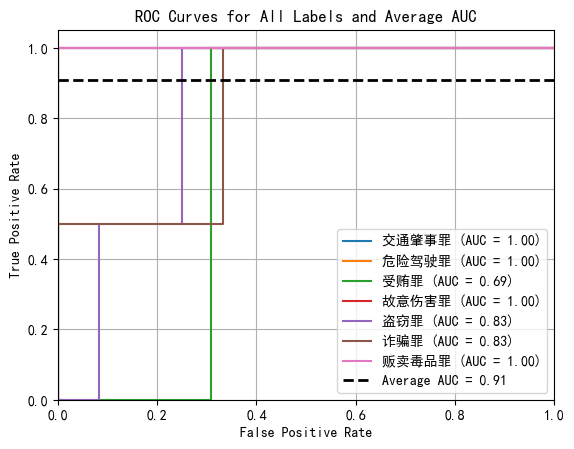

In [28]:
roc_auc, eff_col= 0, 0
# 设置显示中文
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
for i in range(test_labels.shape[1]):
    # 保证有正例
    if test_labels[:, i].sum()> 0:
        # 一个标签下的fpr, tpr
        fpr, tpr, _= roc_curve(test_labels[:, i].numpy(), pred[:, i].numpy())
        # 计算auc值
        roc_auc+= auc(fpr, tpr)
        # 画图
        plt.plot(fpr, tpr, label=f'{list(crime2idx.keys())[i]} (AUC = {auc(fpr, tpr):.2f})')
        eff_col+= 1
avg_auc= roc_auc/ eff_col
# 绘制水平线表示平均 AUC  
avg_fpr= np.linspace(0, 1, 100)
avg_tpr= np.ones_like(avg_fpr)* avg_auc
plt.plot(avg_fpr, avg_tpr, 'k--', lw=2, label=f'Average AUC = {avg_auc:.2f}')  
# 设置图例、标题和坐标轴标签  
plt.legend(loc="lower right")  
plt.title('ROC Curves for All Labels and Average AUC')  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.grid(True)  
# 显示图形  
plt.show()

##### PR曲线

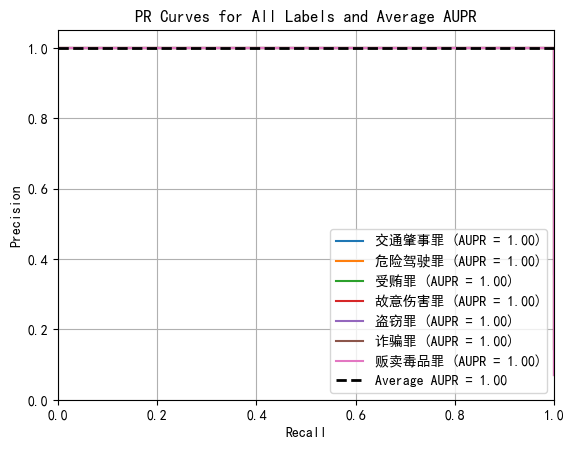

In [34]:
aupr, eff_col= 0, 0
# 设置显示中文
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
for i in range(test_labels.shape[1]):
    if test_labels[:, i].sum()> 0:
        prec, reca, _= precision_recall_curve(test_labels[:, i].numpy(), pred[:, i].numpy())
        aupr+= auc(reca, prec)
        plt.plot(reca, prec, label=f'{list(crime2idx.keys())[i]} (AUPR = {auc(reca, prec):.2f})')
        eff_col+= 1
avg_auc= aupr/ eff_col
# 绘制水平线表示平均 AUC  
avg_call= np.linspace(0, 1, 100)
avg_prec= np.ones_like(avg_call)* avg_auc
plt.plot(avg_call, avg_prec, 'k--', lw=2, label=f'Average AUPR = {avg_auc:.2f}')  
# 设置图例、标题和坐标轴标签  
plt.legend(loc="lower right")
plt.title('PR Curves for All Labels and Average AUPR')  
plt.xlabel('Recall')
plt.ylabel('Precision')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.grid(True)  
# 显示图形  
plt.show()

##### 精确率和召回率

In [30]:
pred01= pred2long(pred)
precision= 0
recall= 0
col_eff= 0
for i in range(test_labels.shape[1]):
    if test_labels[:, i].sum()> 0:
        precision+= precision_score(test_labels[:, i].numpy(), pred01[:, i].numpy())
        recall+= recall_score(test_labels[:, i].numpy(), pred01[:, i].numpy())
        col_eff+= 1
        print(f'在{list(crime2idx.keys())[i]}下的混淆矩阵:\n{confusion_matrix(test_labels[:, i].numpy(), pred01[:, i].numpy())}')
print(f'平均的精确率: {precision/ col_eff}, 平均的召回率: {recall/ col_eff}')

在交通肇事罪下的混淆矩阵:
[[6 3]
 [0 5]]
在危险驾驶罪下的混淆矩阵:
[[12  0]
 [ 2  0]]
在受贿罪下的混淆矩阵:
[[10  3]
 [ 1  0]]
在故意伤害罪下的混淆矩阵:
[[10  3]
 [ 0  1]]
在盗窃罪下的混淆矩阵:
[[9 3]
 [0 2]]
在诈骗罪下的混淆矩阵:
[[8 4]
 [1 1]]
在贩卖毒品罪下的混淆矩阵:
[[13  0]
 [ 0  1]]
平均的精确率: 0.35357142857142854, 平均的召回率: 0.6428571428571429


#### 输入中文事实，进行预测罪行

In [35]:
# 输入中文的事实，输出每个事实的罪名数目，预测模型，罪名字典
def predict_crime(input_facts, output_label_number, net, crime2idx):
    idx2crime= list(crime2idx.keys())
    print('cut words:')
    input_facts_cut= word_cut(input_facts)
    for i in range(len(input_facts)):
        print(f'No {i}\nBefore cut: {input_facts[i]}\nAfter cut: {input_facts_cut[i]}\n')
    input_facts_one_hot= F.one_hot(token2digit(input_facts_cut, token2idx, max_len), len(idx2token)).float()
    for i, input_fact in enumerate(input_facts_one_hot):
        out= net(input_fact.unsqueeze(0).to(device))
        _, idxs= torch.topk(out, output_label_number[i], largest= True)
        print(f'No {i}, computer prediction result:')
        for idx in idxs:print(idx2crime[idx])

In [36]:
# 中文句子数字化
input_facts= ['2010年7月2日21时许，被告人苏学君酒后独自一人走路去其妹妹苏某某家洗澡，当走到与其有矛盾的同村周某某家附近时，看见周某某站在门口，便走到周某某家门口，与周某某发生打斗，在打斗过程中，被告人苏学君用随身携带的刀刺中周某某腹部一刀，后逃离现场。周某某经送医院抢救无效死亡。', '2002年8月15日晚上10时许，被告人潘远清与盘有明、梁发兵、潘达强（三人均已判刑）等人到昭平大酒店皇冠歌舞厅迪吧喝酒，不久，潘达强先行离开，被告人潘远清与盘有明、梁发兵等人发现有公会人在此迪吧活动，于是三人即密谋对公会人采取行动。到了晚上11时30分左右，在此迪吧的公会人先后离开，公会人杨其靖走在最后。被告人潘远清与盘有明、梁发兵尾随杨其靖到大酒店停车场值班室附近时，三人即持尖刀冲向杨其靖朝其身上乱捅、乱打导致杨其靖受伤倒地。杨其靖受伤后大声喊救命，闻讯赶来的潘达强又持平头长砍刀从停车场外冲进来，朝杨其靖又砍两刀。作案后潘远清、盘有明、潘达明、梁发兵逃离现场。被害人杨其靖被送到昭平县人民医院抢救，因伤势过重身亡。案发后，被告人潘远清畏罪潜逃至广东省中山市、东莞市等地，于2011年12月2日主动到公安机关投案。']
output_label_number= [1, 1]
predict_crime(input_facts, output_label_number, net, crime2idx)

cut words:
stop words has loaded...
No 0
Before cut: 2010年7月2日21时许，被告人苏学君酒后独自一人走路去其妹妹苏某某家洗澡，当走到与其有矛盾的同村周某某家附近时，看见周某某站在门口，便走到周某某家门口，与周某某发生打斗，在打斗过程中，被告人苏学君用随身携带的刀刺中周某某腹部一刀，后逃离现场。周某某经送医院抢救无效死亡。
After cut: ['时许', '被告人', '独自一人', '走路', '妹妹', '洗澡', '矛盾', '同村', '周家', '时周站', '门口', '家门口', '发生', '打斗', '打斗', '过程', '被告人', '随身携带', '刺中', '腹部', '逃离现场', '医院', '死亡']

No 1
Before cut: 2002年8月15日晚上10时许，被告人潘远清与盘有明、梁发兵、潘达强（三人均已判刑）等人到昭平大酒店皇冠歌舞厅迪吧喝酒，不久，潘达强先行离开，被告人潘远清与盘有明、梁发兵等人发现有公会人在此迪吧活动，于是三人即密谋对公会人采取行动。到了晚上11时30分左右，在此迪吧的公会人先后离开，公会人杨其靖走在最后。被告人潘远清与盘有明、梁发兵尾随杨其靖到大酒店停车场值班室附近时，三人即持尖刀冲向杨其靖朝其身上乱捅、乱打导致杨其靖受伤倒地。杨其靖受伤后大声喊救命，闻讯赶来的潘达强又持平头长砍刀从停车场外冲进来，朝杨其靖又砍两刀。作案后潘远清、盘有明、潘达明、梁发兵逃离现场。被害人杨其靖被送到昭平县人民医院抢救，因伤势过重身亡。案发后，被告人潘远清畏罪潜逃至广东省中山市、东莞市等地，于2011年12月2日主动到公安机关投案。
After cut: ['时许', '被告人', '清盘', '发兵', '人均', '判刑', '昭平', '大酒店', '皇冠', '歌舞厅', '喝酒', '先行', '离开', '被告人', '清盘', '发兵', '发现', '公会', '活动', '密谋', '公会', '采取行动', '公会', '离开', '公会', '被告人', '清盘', '发兵', '尾随', '大酒店', '停车场', '值班室', '尖刀', '冲向', '身上', '乱打', '导致', '受伤', '倒地', '受伤', '喊救命', 